In [1]:
import time
from pathlib import Path
import textwrap

import numpy as np
import torch
import transformers
from transformers import (AutoConfig, AutoModelForCausalLM, AutoTokenizer,
                          BitsAndBytesConfig)


from modules.GPTQ_loader import load_quantized
from modules.text_generation import generate_reply
import modules.shared as shared
from modules.model import load_model

import hashlib
import spacy
# Load the English language model
nlp = spacy.load("en_core_web_sm")

#shared.model_name = "alpaca-native-4bit"
#shared.model_name = "LLaMA-30B-4bit-128g"
#shared.model_name = "vicuna-13b-GPTQ-4bit-128g"
#shared.model_name = "Wizard-Vicuna-13B-4bit-128g"
#shared.model_name = "LLaMA-7B-HF"


#shared.model_name = "vicuna-7B-v1.5-GPTQ"
#shared.model_name = "_LLama2-7b-gptq-4bit-32g-actorder_True"
shared.model_name = "_Mistral-7b-gptq-4bit-32g-actorder_True"
#shared.model_name = "dolphin-2.1-mistral-7B-gptq-8bit-128g-actorder_True"

print(f"Loading {shared.model_name}...")
t0 = time.time()
#shared.model = load_quantized(shared.model_name)
#shared.tokenizer = AutoTokenizer.from_pretrained(Path(f"models/{shared.model_name}/"))
#shared.tokenizer.truncation_side = 'left'

shared.groupsize = 32
shared.wbits = 4
shared.model, shared.tokenizer = load_model(shared.model_name, gptq = True)

print(f"Loaded the model in {(time.time()-t0):.2f} seconds.")


import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']




#words = df.iloc[:, 0]
#value = df.iloc[:, 34]

#selected_columns = df[['Word', 'Dominant.sensorimotor']]  # Specify the columns you want to convert to a dictionary
#shared.sensorimotor = selected_columns.set_index('Word')['Dominant.sensorimotor'].to_dict()
#{'Visual': 22774, 'Auditory': 2690, 'Head': 7740, 'Torso': 223, 'Interoceptive': 1766, 'Mouth': 1166, 'Haptic': 649, 'Hand_arm': 1434, 'Gustatory': 661, 'Foot_leg': 428, 'Olfactory': 176}

#classes_to_remove = ['Torso', 'Haptic', 'Gustatory', 'Foot_leg', 'Olfactory']
#shared.sensorimotor = {item: class_name for item, class_name in shared.sensorimotor.items() if class_name not in classes_to_remove}

#shared.classes = list(set(shared.sensorimotor.values()))

from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli",device=-1)

def secure_hash_to_numbers(input_string, range_list):

    
    nlp = spacy.load("en_core_web_sm")

    if (input_string is None):
        return [5,5]
    doc = nlp(input_string)

    core = [token.lemma_ for token in doc if not token.is_stop]

    core_str = " ".join(core)

    input_string = core_str
    '''
    hashed_bytes = hashlib.sha256(core_str.encode()).digest()

    num_numbers = len(range_list)
    hashed_integers = [int.from_bytes(hashed_bytes[i:i+4], byteorder='big') for i in range(0, num_numbers * 4, 4)]

    #cast hash to integer, then use modulo to map to required range
    result_numbers = []
    for i in range(num_numbers):
        range_min, range_max = range_list[i]
        integer = hashed_integers[i]
        mapped_number = (integer % (range_max - range_min + 1)) + range_min
        result_numbers.append(mapped_number)
    
    '''
    
    
    '''
    import subprocess
    def run_classifier(param):
        # Replace 'your_conda_env' with the name of your Conda environment
        run_classifier_script = f"mamba run -n classifier python classifier.py '{param}'"
        command = f"/bin/bash -c '{run_classifier_script}'"

        # Run the command and capture output
        completed_process = subprocess.run(command, shell=True, text=True, capture_output=True)
        return completed_process.stdout.strip()

    # Rest of your LLM code
    # ...
    # Call the function where needed and pass the parameter
    classifier_output = run_classifier("This is a test.")
    print("Output from classifier:", classifier_output)
    '''
    
    
    labels = [
        "Statement",      # Declarative statements or assertions
        "Question",       # Any form of inquiry or query
        "Request",        # Sentences that ask for something
        "Command",        # Imperative or directive statements
        "Offer",          # Proposals or suggestions
        "Explanation",    # Providing clarifications or reasons
        "Description",    # Descriptive details about something
        "Opinion",        # Personal views or judgments
        "Fact",           # Factual or objective information
        "Assumption",     # Sentences based on assumptions
        "Belief",         # Expressions of belief or conviction
        "Doubt",          # Expressions of uncertainty or skepticism
        "Hope",           # Sentences expressing hope or aspiration
        "Wish",           # Expressions of desires or wishes
        "Fear",           # Statements expressing fear or concern
        "Joy",            # Expressions of happiness or joy
        "Sadness",        # Expressions of sorrow or sadness
        "Anger",          # Statements expressing anger or frustration
        "Surprise",       # Expressions of surprise or astonishment
        "Sarcasm",        # Sarcastic or ironic statements
        "Joke",           # Humorous or joking statements
        "Quote",          # Quotations or cited speech
        "Agreement",      # Expressions of agreement or affirmation
        "Disagreement",   # Expressions of disagreement or dissent
        "Gratitude",      # Expressions of thanks or appreciation
        "Apology"         # Statements of apology or regret
    ]
    labels = ['Scientific Concepts',
        'Technical Explanations',
        'Historical Context',
        'Cultural Insights',
        'Environmental Issues',
        'Health and Medicine',
        'Technological Developments',
        'Economic Theories',
        'Political Analysis',
        'Philosophical Concepts',
        'Educational Methods',
        'Psychological Theories',
        'Artistic Movements',
        'Literary Analysis',
        'Global Events',
        'Culinary Traditions',
        'Mathematical Concepts',
        'Physical Principles',
        'Astronomical Discoveries',
        'Geographical Information',
        'Social Dynamics',
        'Legal Interpretations',
        'Business Strategies',
        'Sports and Fitness',
        'Linguistic Features',
        'Techniques in Science and Technology']

    labels2 = [
        "Health",
        "Technology",
        "Politics",
        "Economy",
        "Education",
        "Environment",
        "Sports",
        "Travel",
        "Food",
        "Music",
        "Business"
    ]
    labels2 = ['Science and Technology',
        'Health and Environmental Issues',
        'Arts, Culture, and History',
        'Economic and Political Analysis',
        'Philosophy and Psychology',
        'Education and Learning Methods',
        'Global and Social Dynamics',
        'Legal and Ethical Discussions',
        'Business and Management',
        'Sports, Fitness, and Recreation',
        'Language and Literature']
        

    results = classifier(input_string, labels)
    predicted_label = results['labels'][0]
    label_index = labels.index(predicted_label)

    results2 = classifier(input_string, labels2)
    predicted_label2 = results2['labels'][0]
    label_index2 = labels2.index(predicted_label2)
   
    #print(input_string)
    #print([label_index2, label_index])
    #print("--------------------------")
    return [label_index2, label_index]
    
    
    #return result_numbers

def get_last_sentence(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    if sentences:
        return sentences[-1]
    else:
        return None  # Return None if there are no sentences


Loading _Mistral-7b-gptq-4bit-32g-actorder_True...
Loading _Mistral-7b-gptq-4bit-32g-actorder_True...
Auto-assiging --gpu-memory 23 for your GPU to try to prevent out-of-memory errors. You can manually set other values.
The AutoGPTQ params are: {'model_basename': 'model', 'device': 'cuda:0', 'use_triton': False, 'inject_fused_attention': False, 'inject_fused_mlp': False, 'use_safetensors': True, 'trust_remote_code': True, 'max_memory': {0: '23GiB', 'cpu': '64GiB'}, 'quantize_config': None, 'disable_exllama': True}
Loaded the model in 36.19 seconds.

Loaded the model in 36.19 seconds.


In [140]:
from collections import Counter
import re

def most_common_letters(text, num_letters=3):
    sentences = re.split(r'[.!?]+', text.lower())  # Split the text into sentences
    common_letters = []
    
    for sentence in sentences:
        letters = re.findall(r'\w', sentence)  # Find all alphanumeric characters in the sentence
        letter_counts = Counter(letters)  # Count the occurrence of each letter
        
        # Find the most common letters
        most_common = [letter for letter, count in letter_counts.most_common(num_letters)]
        
        common_letters.append(most_common)
    
    return common_letters

def first_letters(text):
    sentences = re.split(r'[.!?]+', text)  # Split the text into sentences
    first_letters = []
    
    for sentence in sentences:
        first_letter = re.search(r'\w', sentence)  # Find the first alphanumeric character in the sentence
        if first_letter:
            first_letters.append(first_letter.group())
    
    return first_letters


#table = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv')
#table = pd.read_csv('your_file.csv', sep='\t')


In [2]:
#question = "### Human: Explain in detail: What is the Nordschleife? ### Assistant:"

#question = "A chat between a human and an assistant. ### HUMAN: What is Formula One? ### ASSISTANT:"

#question = "What is Formula One?"

prompt = "Describe the structure of the Earth's atmosphere."
system_message = "You are a helpful assistant."

question = f'''<|im_start|>system
You are Dolphin, a helpful AI assistant.<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start>assistant'''

generate_params = {
    'max_new_tokens' : 200,
    'add_bos_token' : False,
    'truncation_length' : 4096,
    'custom_stopping_strings' : ["### Human:", "Human:", "user:", "Q:","<|im_end|>"],
    'ban_eos_token' : False,
    'skip_special_tokens' : False,
    'do_sample': True,
    'temperature': 0.7,
    'top_p': 0.95,
    'typical_p': 1,
    'repetition_penalty': 1.10,
    'encoder_repetition_penalty': 1,
    'top_k': 40,
    'num_beams': 1,
    'penalty_alpha': 0,
    'min_length': 0,
    'length_penalty': 1,
    'no_repeat_ngram_size': 0,
    'early_stopping': False,
    'seed' : 0,
}
shared.delta_char = 2.0
shared.delta_first = 3.5
shared.code = "tugraz"

shared.secret_key = [0,0]
reply = generate_reply(question, generate_params)

wrapped_string = "\n".join(textwrap.wrap(reply, width=150))
print(wrapped_string)




Output generated in 11.27 seconds (1.42 tokens/s, 16 tokens, context 61, seed 0)
 The earth’s atmosphere is a layer of gases surrounding the planet.


Traceback (most recent call last):
  File "/home/georg/master-generation/modules/text_generation.py", line 426, in generate_reply
    shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
  File "/home/georg/master-generation/modules/text_generation.py", line 112, in secure_hash_to_numbers
    label_number2 = label_to_number2[most_likely_label2]
NameError: name 'label_to_number2' is not defined


In [9]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math

from scipy.stats import binom

def secure_hash_to_numbers(input_string, range_list):
    hashed_bytes = hashlib.sha256(input_string.encode()).digest()
    

    num_numbers = len(range_list)
    hashed_integers = [int.from_bytes(hashed_bytes[i:i+4], byteorder='big') for i in range(0, num_numbers * 4, 4)]

    #cast hash to integer, then use modulo to map to required range
    
    result_numbers = []
    for i in range(num_numbers):
        range_min, range_max = range_list[i]
        integer = hashed_integers[i]
        mapped_number = (integer % (range_max - range_min + 1)) + range_min
        result_numbers.append(mapped_number)
    
    return result_numbers

range_list = [(0, 10), (0, 25)] 
# Load the English language model
nlp = spacy.load("en_core_web_sm")

def split_into_sentences(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]

print(shared.classes)

mean = {'Auditory.mean': 0.0, 'Gustatory.mean': 0.0,'Haptic.mean': 0.0,'Interoceptive.mean': 0.0,'Olfactory.mean': 0.0,'Visual.mean': 0.0,'Foot_leg.mean': 0.0,'Hand_arm.mean': 0.0,'Head.mean': 0.0,'Mouth.mean': 0.0,'Torso.mean': 0.0}
valid_key = 0
for key in shared.vocab_decode:
    if key.upper() in shared.sensorimotor:
        valid_key += 1
        for i in range(10):
                mean[shared.classes[i]] += shared.sensorimotor[key.upper()][shared.classes[i]]


mean = {key: value / valid_key for key, value in mean.items()}
z_scores = []
probabilities = []
correct_acrosticons = 0
old_class = 0

#reply = "When the full-scale invasion began in 2022, Mariinka came under relentless Russian attack and was evacuated. The head of the Ukrainian Air Force said warplanes had destroyed the landing ship Novocherkassk, used for moving troops and heavy equipment, in the early hours of Tuesday. Mr Shoigu gave details on Tuesday of the damage to the ship to President Vladimir Putin, before declaring that Russian forces had brought Ukraine's counter-offensive to a halt and were now pushing forward on all fronts. Mariinka, once home to 10,000 people, has remained in Ukrainian hands throughout the Kremlin's war in eastern Ukraine, which began when Russia seized and annexed Crimea in 2014 and its proxy forces occupied parts of the Donetsk and Luhansk regions. MS researchers who published a paper about GPT4 and its intelligence mentioned that the model becomes dumber over time as more and more safety and alignment was added over time. I think one possible reason that official prompt format could under perform is the additional alignment done using the official prompt format during fine tuning that degrades the model performance. As such, avoid official prompt format also bypasses some alignment as I witnessed, and improves performance as you saw in your test."
#reply = "MS researchers who published a paper about GPT4 and its intelligence mentioned that the model becomes dumber over time as more and more safety and alignment was added over time. I think one possible reason that official prompt format could under perform is the additional alignment done using the official prompt format during fine tuning that degrades the model performance. As such, avoid official prompt format also bypasses some alignment as I witnessed, and improves performance as you saw in your test."
sentences = split_into_sentences(reply)
for idx, sentence in enumerate(sentences, start=1):

    if idx > 1:
        if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
            correct_acrosticons += 1

    generated_numbers = secure_hash_to_numbers(sentence, range_list)


    word_list = get_words_in_sentence(sentence)

    values = {'Auditory.mean': 0.0, 'Gustatory.mean': 0.0,'Haptic.mean': 0.0,'Interoceptive.mean': 0.0,'Olfactory.mean': 0.0,'Visual.mean': 0.0,'Foot_leg.mean': 0.0,'Hand_arm.mean': 0.0,'Head.mean': 0.0,'Mouth.mean': 0.0,'Torso.mean': 0.0}

    valid_key = 0
    for key in word_list:
        if key.upper() in shared.sensorimotor:
            valid_key += 1
            for i in range(11):
                values[shared.classes[i]] += shared.sensorimotor[key.upper()][shared.classes[i]]
            #value_counts[shared.sensorimotor[key.upper()]] += 1

    values = {key: value / valid_key for key, value in values.items()}

    #DEBUG print
    #for value, count in values.items():
    #    print(f"{value}: {count} ", end="")
    #print()

    sorted_items = (dict(sorted(values.items(), key=lambda item: item[1], reverse=True)))

    #DEBUG print
    #for key in sorted_items:
    #    print(key , end=" " )
    #print()

    #print('Value: ',  values[shared.classes[old_class]], ' Mean: ', mean[shared.classes[old_class]])

    # Calculate Z-score for the new data point
    z_score = (values[shared.classes[old_class]] - mean_value[old_class]) / std_deviation[old_class]

    # Calculate the probability using the cumulative distribution function (CDF)
    probabilities.append(1-norm.cdf(z_score))
    z_scores.append(z_score)

    print(f"Sentence {idx}: {sentence}")
    print(chr(ord('A') + generated_numbers[1]), shared.classes[generated_numbers[0]] )

    

    old_class = generated_numbers[0]




def probability_of_acrosticon(n_trials, x):
    # Probability of success
    p_success = 1/26


    # Use the binomial probability mass function to calculate the probability
    probability = binom.pmf(x, n_trials, p_success)

    return probability

acrosticon_restult = probability_of_acrosticon(len(sentences)-1,correct_acrosticons)
print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

# Example usage:
stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
print(probabilities)
print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
print(f"The total probability is: {stouffer_result*acrosticon_restult}")

['Auditory.mean', 'Gustatory.mean', 'Haptic.mean', 'Interoceptive.mean', 'Olfactory.mean', 'Visual.mean', 'Foot_leg.mean', 'Hand_arm.mean', 'Head.mean', 'Mouth.mean', 'Torso.mean']
Sentence 1: 
A cat is a domesticated animal, a small carnivorous mammal that is a member of the family Felidae.
R Mouth.mean
Sentence 2: Cats have a reputation for being independent and self-contained but they are capable of forming strong emotional bonds with their human caregivers, often forming crews with them based on food, play, and affection.
B Visual.mean
Sentence 3: Because of this behavior some people view them as little children in fur coats.
D Haptic.mean
Sentence 4: Despite being small, cats can be both fierce predators and fearsome hunters due to being physically smaller than many other large felines.
J Mouth.mean
Sentence 5: They use their teeth, claws, agility, camouflage, pouncing, and speed to catch prey and defend themselves from threats.
T Gustatory.mean
Sentence 6: They also produce purrs

In [12]:
print(most_common_letters(reply,5))

from scipy.stats import zscore
from scipy.stats import norm

# Your original dataset
original_data = [10, 15, 20, 25, 30]

# Calculate mean and standard deviation
#mean_value = sum(original_data) / len(original_data)
#std_deviation = (sum((x - mean_value) ** 2 for x in original_data) / len(original_data)) ** 0.5

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]

# New data point
new_data_point = 22

# Calculate Z-score for the new data point
z_score = (new_data_point - mean_value) / std_deviation

# Calculate the probability using the cumulative distribution function (CDF)
probability = norm.cdf(z_score)
print(probability)

[['r', 'n', 'o', 'a', 'e'], ['e', 'r', 'i', 'n', 'a'], ['e', 'r', 'a', 's', 't'], ['e', 'i', 's', 'h', 'n'], ['e', 'a', 't', 'n', 'i'], ['e', 'o', 'i', 's', 'n']]
0.6113512946052392


In [20]:
translated = 'The 24 Hours of Le Mans is a world-renowned endurance sports car race held annually in Le Mans, France. Unlike most other motorsport events, which usually consist of short sprint races that last only a few minutes or hours, the 24 Hours of Le Mans is a true test for the drivers and their machines, spanning an entire day and night. GT engines are built to maintain high power levels for long periods of time without failure, unlike supercars that have tremendous power but a much shorter life under such conditions. Race cars designed for this competition must be lightweight, aerodynamic and highly efficient in terms of fuel consumption and tire wear. In addition, driver strategy plays a critical role in determining the winner, as teams must carefully manage their drivers changes and pit strategies throughout the race to ensure their car remains competitive from start to finish. Zero waste and maximum performance are essential aspects that make the Le Mans race a fascinating challenge and a great success for any team that can take home the trophy at the end of the race. To achieve the goal of waste reduction, organizations such as the Automobile Club de l Ouest (ACO), which organizes the event, have taken various initiatives to reduce the environmental impact of the race. Understanding these factors underscores the importance of optimizing through technology to achieve the best result with the least negative impact on the environment, while maintaining the thrill and excitement associated with top-level motorsports competition. GT engines used in such events must be carefully tuned and matched to ensure they run efficiently during the grueling duration of the race without causing unnecessarily harmful emissions or excessive fuel consumption. Race regulations also play an important role in encouraging engine designers to develop more energy-efficient engines that produce less waste and pollutants during the race. Research into advanced materials for better aerodynamics or lighter weight supports efforts to create greener racing experiences for future generations. Zero waste and maximum performance are achievable goals that can coexist and even reinforce each other when approached with innovative and forward-thinking approaches that take into account all relevant factors affecting automotive mechanics and dynamics at major racing events such as the 24 Hours of Le Mans.'
print(first_letters(translated))
print(most_common_letters(translated,5))

['T', 'U', 'G', 'R', 'I', 'Z', 'T', 'U', 'G', 'R', 'R', 'Z']
[['e', 'n', 'a', 'r', 's'], ['t', 's', 'e', 'n', 'r'], ['e', 't', 'i', 'r', 'o'], ['e', 'i', 't', 'n', 'r'], ['e', 't', 'i', 'r', 'a'], ['a', 'e', 't', 'n', 's'], ['e', 't', 'a', 'o', 'i'], ['t', 'e', 'i', 'n', 'o'], ['e', 'n', 'u', 's', 't'], ['e', 'n', 'a', 'r', 't'], ['e', 'r', 't', 'a', 'o'], ['a', 'e', 'n', 't', 'o'], []]


In [26]:
question = "### Human: Explain in detail: What is the 24 Hours of Le Mans? ### Assistant:"


generate_params = {
    'max_new_tokens' : 500,
    'add_bos_token' : False,
    'truncation_length' : 2048,
    'custom_stopping_strings' : ["### Human:", "Human:", "user:"],
    'ban_eos_token' : False,
    'skip_special_tokens' : False,
    'do_sample': True,
    'temperature': 0.7,
    'top_p': 0.1,
    'typical_p': 1,
    'repetition_penalty': 1.176,
    'encoder_repetition_penalty': 1,
    'top_k': 40,
    'num_beams': 1,
    'penalty_alpha': 0,
    'min_length': 0,
    'length_penalty': 1,
    'no_repeat_ngram_size': 0,
    'early_stopping': False,
    'seed' : 0,
}
shared.delta_char = 5.00
shared.delta_first = 50.0
shared.code = "tugraz"

shared.secret_key = [0,0]
reply = generate_reply(question, generate_params)

wrapped_string = "\n".join(textwrap.wrap(reply, width=150))
print(wrapped_string)




### Human: Explain in detail: What is the 24 Hours of Le Mans? ### Assistant:
--------------------
 The 24 Hours of Le Mans is a endurance race that takes place at the Circuit de la Sarthe, near the town of Le Mans, France.
[2, 16]
Q
Qualifying races are held to determine starting positions and set the grid for the main event.
[1, 6]
G
Grid positions and the specific cars and drivers participating are determined by the qualifying results and the specific class of the car being entered into the competition.
[4, 23]
X
X P
The race itself take approximately 24 hours to complete with teams consisting of two or three drivers making pit stops as needed during the course of the race.
[0, 16]
Q
Output generated in 35.29 seconds (14.14 tokens/s, 499 tokens, context 24, seed 0)
 The 24 Hours of Le Mans is a endurance race that takes place at the Circuit de la Sarthe, near the town of Le Mans, France. Qualifying races are held
to determine starting positions and set the grid for the main event.

In [11]:
#question = "### Human: Explain in detail: What is the Nordschleife? ### Assistant:"

#question = "A chat between a human and an assistant. ### HUMAN: What is Formula One? ### ASSISTANT:"

#question = "What is Formula One?"
progress = 0
prompts = [
    "What is the concept of artificial intelligence?",
    "How does photosynthesis work in plants?",
    "Who is the author of the famous play 'Romeo and Juliet'?",
    "Explain the theory of relativity proposed by Albert Einstein.",
    "What are the main features of a black hole?",
    "Describe the process of DNA replication in cells.",
    "Who painted the Mona Lisa and why is it famous?",
    "What is the significance of the Industrial Revolution in history?",
    "Explain the principles of supply and demand in economics.",
    "Who is known as the 'Father of Modern Physics'?",
    "What are the major causes of climate change?",
    "Describe the structure and function of the human nervous system.",
    "Who wrote the classic novel 'Pride and Prejudice'?",
    "What are the key components of a computer's central processing unit (CPU)?",
    "Explain the process of evolution by natural selection.",
    "Who is credited with the invention of the World Wide Web?",
    "Describe the major events of the American Civil War.",
    "What is the role of mitochondria in a cell?",
    "Who is the current president of France?",
    "What are the main features of a Shakespearean sonnet?",
    "Explain the concept of quantum entanglement in physics.",
    "Who discovered penicillin and how did it revolutionize medicine?",
    "Describe the structure of the Earth's atmosphere.",
    "What is the significance of the Magna Carta in legal history?",
    "Who is the author of 'The Great Gatsby'?",
    "Explain the principles of the theory of plate tectonics.",
    "What are the different forms of renewable energy sources?",
    "Who won the Nobel Prize in Physics in the year 2020?",
    "Describe the process of cellular respiration in living organisms.",
    "Who is considered the 'Father of Modern Chemistry'?"
]


prompts = [
    "What is the capital of France?",
    "Explain the process of photosynthesis.",
    "What are the basic rules of chess?",
    "Describe the water cycle.",
    "Summarize the plot of 'Romeo and Juliet'.",
    "What is Newton's first law of motion?",
    "How do you make a simple omelette?",
    "List the seven continents.",
    "What are the primary colors?",
    "Explain the concept of supply and demand in economics.",
    "What is the function of the heart in the human body?",
    "How does a compass work?",
    "Define the term 'ecosystem'.",
    "What is the boiling point of water?",
    "Describe how a computer works.",
    "What are the planets in our solar system?",
    "Explain the basics of HTML.",
    "Who was Albert Einstein?",
    "What is the Pythagorean theorem?",
    "How do you calculate the area of a circle?",
    "What is photosynthesis?",
    "Describe the life cycle of a butterfly.",
    "What is the Declaration of Independence?",
    "How do you change a flat tire?",
    "What is the process of evaporation?",
    "Explain the rules of soccer.",
    "What is the significance of the Great Wall of China?",
    "How do solar panels generate electricity?",
    "What causes earthquakes?",
    "Describe the structure of DNA.",
    "What is a black hole?",
    "How do airplanes fly?",
    "Explain the concept of gravity.",
    "What is global warming?",
    "Describe the human digestive system.",
    "What is the Renaissance?",
    "How does the stock market work?",
    "What are renewable energy sources?",
    "Explain the basic principles of democracy.",
    "What is virtual reality?",
    "How do vaccines work?",
    "What is the internet?",
    "Describe the process of making chocolate.",
    "What is a haiku?",
    "How do bees make honey?",
    "What is the theory of relativity?",
    "Explain the function of the lungs.",
    "What is a balanced diet?",
    "Describe the phases of the moon.",
    "What is artificial intelligence?",
    "How does a refrigerator work?",
    "Explain the concept of time zones.",
    "What is the significance of the Mona Lisa?",
    "How is glass made?",
    "What are the causes of World War II?",
    "Explain the importance of biodiversity.",
    "What is the structure of an atom?",
    "How does a camera work?",
    "What is mindfulness?",
    "Describe the process of recycling."
]

prompts = [
    "What causes the seasons to change?",
    "Describe the French Revolution.",
    "What is quantum mechanics?",
    "How do you solve a quadratic equation?",
    "What is the significance of the Berlin Wall?",
    "Explain the process of fermentation.",
    "What is the human genome project?",
    "How does the internet work?",
    "What are the symptoms of diabetes?",
    "Describe the process of cell division.",
    "What is the theory of evolution?",
    "How do you make bread?",
    "What are the major religions of the world?",
    "Explain the concept of inflation in economics.",
    "What is the significance of the Magna Carta?",
    "How does a microwave oven work?",
    "What is the structure of the United Nations?",
    "Describe the American Civil War.",
    "What causes tsunamis?",
    "How do you write a business plan?",
    "What is the importance of the Rosetta Stone?",
    "Explain the principles of non-violent resistance.",
    "What is a supernova?",
    "How do you calculate compound interest?",
    "Describe the process of photosynthesis in detail.",
    "What is the impact of climate change on oceans?",
    "Explain the concept of blockchain.",
    "What is the importance of the Silk Road?",
    "How do antibiotics work?",
    "Describe the Greek pantheon of gods.",
    "What is dark matter?",
    "How do you make a website?",
    "Explain the process of nuclear fusion.",
    "What is the history of the internet?",
    "Describe the principles of classical architecture.",
    "What causes volcanic eruptions?",
    "How do you create a budget?",
    "What is the importance of the Suez Canal?",
    "Explain the concept of artificial selection.",
    "What is the difference between mitosis and meiosis?",
    "Describe the Crusades.",
    "What is the formula for calculating velocity?",
    "How does a sewing machine work?",
    "What is the significance of the Dead Sea Scrolls?",
    "Explain the basics of cryptocurrency.",
    "What is the function of the kidneys in the human body?",
    "Describe the battle of Gettysburg.",
    "What causes global economic crises?",
    "How do you make a pizza?",
    "What is the theory behind black holes?",
    "Describe the structure and function of the brain.",
    "What is the significance of Machu Picchu?",
    "How does a light bulb work?",
    "Explain the concept of the Big Bang Theory.",
    "What is the role of the World Health Organization?",
    "Describe the process of making wine.",
    "What is the importance of quantum computing?",
    "How do you improve your memory?",
    "What is the story behind the Trojan War?",
    "Describe the function of the immune system.",
    "What causes lightning and thunder?",
    "How do you calculate BMI (Body Mass Index)?",
    "What is the significance of Stonehenge?",
    "Explain the concept of virtual private networks (VPNs).",
    "What is the difference between renewable and non-renewable energy?",
    "Describe the process of making beer.",
    "What is the significance of the Panama Canal?",
    "How does a GPS system work?",
    "What is the history of the Olympic Games?",
    "Explain the concept of machine learning.",
    "What is the importance of the Gutenberg Bible?",
    "How do you make a campfire?",
    "What causes addiction?",
    "Describe the process of making cheese.",
    "What is the significance of the Hagia Sophia?",
    "How does Bluetooth technology work?",
    "What is the history of cryptography?",
    "Explain the concept of sustainable development.",
    "What is the importance of the International Space Station?",
    "How do you make chocolate chip cookies?",
    "What causes allergies?",
    "Describe the process of making soap.",
    "What is the significance of the Colosseum in Rome?",
    "How does nuclear power work?",
    "What is the history of the English language?",
    "Explain the concept of the electoral college in the United States.",
    "What is the importance of the Human Rights Declaration?",
    "How do you make a smoothie?",
    "What causes migraines?",
    "Describe the process of making tea.",
    "What is the significance of the Taj Mahal?",
    "How does solar energy work?",
    "What is the history of the Roman Empire?",
    "Explain the concept of photosynthesis in algae.",
    "What is the importance of the Great Barrier Reef?",
    "How do you make a latte?",
    "What causes insomnia?",
    "Describe the process of making sushi.",
    "What is the significance of the Great Pyramid of Giza?",
    "How does wind energy work?",
    "What is the history of the Vikings?",
    "Explain the concept of genetic engineering.",
    "What is the importance of the Mona Lisa in the art world?",
]


results = []


for prompt in prompts:
#prompt = "What is the capital of France?"
    question = f'''<|im_start|>system
You are a helpful assistant, who always provide explanation. Don't enumerate anwsers, talk for the user, write links or urls or use numbers.<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start>assistant
'''

    generate_params = {
        'max_new_tokens' : 200,
        'add_bos_token' : False,
        'truncation_length' : 4096,
        'custom_stopping_strings' : ["### Human:", "Human:", "user:", "Q:","<|im_end|>","<|im_start|>system"],
        'ban_eos_token' : False,
        'skip_special_tokens' : False,
        'do_sample': True,
        'temperature': 0.7,
        'top_p': 0.95,
        'typical_p': 1,
        'repetition_penalty': 1.17,
        'encoder_repetition_penalty': 1,
        'top_k': 40,
        'num_beams': 1,
        'penalty_alpha': 0,
        'min_length': 0,
        'length_penalty': 1,
        'no_repeat_ngram_size': 0,
        'early_stopping': False,
        'seed' : 0,
    }
    shared.delta_char = 0.0
    shared.delta_first = 0.0
    shared.secret_key = [0,0]
    done = False
    reply_base = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.start = 0
    shared.delta_senso = 0
    i = 0
    while (done is not True and i < 15):
        reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

        last_sentence = get_last_sentence(reply_current)
        #print("------------------found end of sentence, last sentence is:")
        #print(f'''[{reply_current}]''')
        shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
        shared.new_sentence = True
        shared.start = 0
        reply_base += reply_current
        current_question = f'''{current_question}{reply_current}'''
        i+=1

    shared.delta_char = 2.5#2.5
    shared.delta_first = 20.0#50
    shared.secret_key = [0,0]

    done = False
    reply_watermark = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.start = 0
    shared.delta_senso = 0
    i = 0
    while (done is not True and i < 20):
        reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

        last_sentence = get_last_sentence(reply_current)
        #print("------------------found end of sentence, last sentence is:")
        #print(f'''[{reply_current}]''')
        shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
        shared.new_sentence = True
        shared.start = 0
        reply_watermark += reply_current
        current_question = f'''{current_question}{reply_current}'''
        i+=1



    #results.append([prompt,reply_base,reply_watermark])
    results.append([prompt,reply_base,reply_watermark])


    #reply_watermark = generate_reply(question+reply_watermark, generate_params, eos_token='<|im_end|>')
    progress += 1
    print(progress)
    print(prompt)
    print(f'''[{reply_base}]''')
    print(f'''[{reply_watermark}]''')


1
What causes the seasons to change?
[The earth is tilted on its axis so that it gets more direct sunlight at certain times of year than others.]
[The earth is tilted on its axis so that it gets more direct sunlight at certain times of year than others.]
2
Describe the French Revolution.
[The French Revolution was a period of far-reaching socio political upheaval in France that lasted from 1789 until 1799 and saw the end of the monarchy as well as the execution of King Louis XVI.The revolution began with the Estates General, which met to discuss ways to reform the financial problems facing France. However, the Third Estate (representing common citizens) wanted more power while the other two estates were against this. As tensions grew between the three estates, riots broke out, leading to the storming of the Bastille. The people took control of Paris, and the king was forced to agree to major reforms. Many people became involved in politics for the first time, forming clubs such as the 

In [3]:
import csv

# Specify the file name
file_name = "output_gen6.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(results)

In [3]:
import csv

def load_csv_to_list(filename):
    data_list = []
    with open(filename, 'r', encoding='utf-8') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            # Assuming each row has the format: [prompt, reply_base, reply_watermark]
            if len(row) == 3:  # Making sure the row has exactly 3 elements
                data_list.append(row)
    return data_list

# Example usage
filename = 'output_gen5.csv'
results = load_csv_to_list(filename)

In [4]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math
import modules.shared as shared

from scipy.stats import binom

def split_into_sentences(text):
    doc = nlp(text)
    sentences = []
    current_sentence = []

    for token in doc:
        current_sentence.append(token.text)
        if token.text in (".", "?", "!"):
            sentences.append(" ".join(current_sentence))
            current_sentence = []

    # Add the last sentence if not followed by a punctuation mark
    if current_sentence:
        sentences.append(" ".join(current_sentence))

    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]


def calculate_probs(reply):
    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    old_class = 0

    sentences = split_into_sentences(reply)
    for idx, sentence in enumerate(sentences, start=1):
        print(sentence)
        if idx > 1:
            if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
                correct_acrosticons += 1

        range_list = [(0, 10), (0, 25)] 
        generated_numbers = secure_hash_to_numbers(sentence, range_list)


        sum_of_word_mean = 0
        valid_words = 0
        words = get_words_in_sentence(sentence)
        for word in words:
            if word.upper() in shared.sensorimotor:
                valid_words += 1
                sum_of_word_mean += shared.sensorimotor[word.upper()][shared.classes[old_class]]

        if(valid_words > 0):
            sentence_value = sum_of_word_mean/valid_words

            # Calculate Z-score for the new data point
            z_score = (sentence_value - mean_value[old_class]) / std_deviation[old_class]
        else:
            z_score = 0

        # Calculate the probability using the cumulative distribution function (CDF)
        probabilities.append(1-norm.cdf(z_score))
        z_scores.append(z_score)

        old_class = generated_numbers[0]



    def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


    acrosticon_restult = probability_of_acrosticon(correct_acrosticons, len(sentences)-1)
    #print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

    # Example usage:
    stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
    #print(probabilities)
    #print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
    #print(f"The total probability is: {stouffer_result*acrosticon_restult}")

    #return stouffer_result*acrosticon_restult, len(sentences), correct_acrosticons
    return stouffer_result*acrosticon_restult, stouffer_result, acrosticon_restult, len(sentences), correct_acrosticons

scores = []
for tuple in results:
    score_base, stouffer_result_base, acrosticon_restult_base, len_base, acros_base = calculate_probs(tuple[1])
    score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark = calculate_probs(tuple[2])

    scores.append([[score_base,stouffer_result_base, acrosticon_restult_base,len_base,acros_base],[score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark]])



To make homemade ice cream , you will need to gather all of your ingredients and put them in a large bowl .
Then , you will add some milk and sugar , as well as any other flavorings that you would like .
Finally , you will pour it into a freezer - safe container and let it freeze overnight .
In the morning , you can enjoy your delicious homemade ice cream !
To make homemade ice cream , you will need to gather all of your ingredients and equipment first .
Place everything together on top of your counter so you can see all of it at once .
Then gather up everything else you need before starting anything !
You can put everything right back where they belong when you have made everything that is on this list !
Take note if there is something missing from what you have prepared already or add something new as well- do not forget anything important like measuring cups or measuring spoons because these items help measure out ingredients correctly while making food quickly without having any me

In [5]:


# Specify the file name
file_name = "output_score5.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(scores)

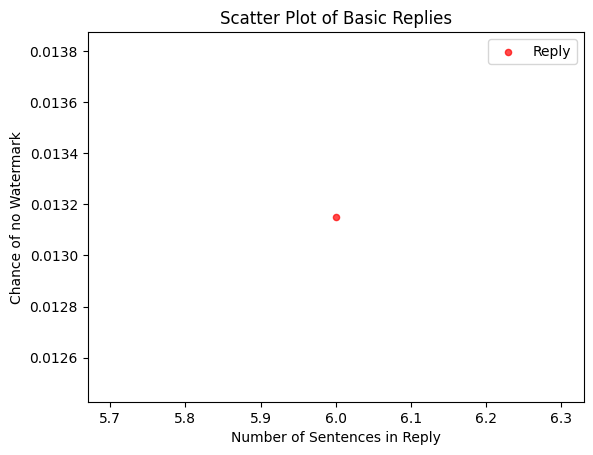

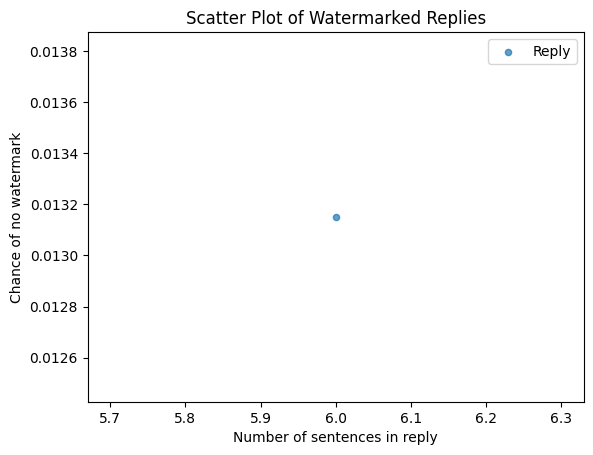

In [8]:
import matplotlib.pyplot as plt

# Extracting x, y coordinates for the scatter plot
y_values = [item[0][2] for item in scores]
x_values = [item[0][3] for item in scores]

# Creating a scatter plot
plt.scatter(x_values, y_values, s=20, alpha=0.7, c=['red'],marker='o', label='Reply')

# Adding labels and title
plt.xlabel('Number of Sentences in Reply')
plt.ylabel('Chance of no Watermark')
plt.title('Scatter Plot of Basic Replies')


# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

# Extracting x, y coordinates for the scatter plot
y_values = [item[1][2] for item in scores]
x_values = [item[1][3] for item in scores]

# Creating a scatter plot
plt.scatter(x_values, y_values, s=20, alpha=0.7, marker='o', label='Reply')

# Adding labels and title
plt.xlabel('Number of sentences in reply')
plt.ylabel('Chance of no watermark')
plt.title('Scatter Plot of Watermarked Replies')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()



[([0.49741510700655195, 0.5595243469278182, 0.8889963586709148, 4, 0], [9.060794671454538e-18, 0.010277127649183315, 8.816466021198604e-16, 15, 12]), ([0.6669241392719034, 0.6669241392719034, 1.0, 1, 0], [0.6669241392719034, 0.6669241392719034, 1.0, 1, 0]), ([0.2042418202772842, 0.36782797978128556, 0.5552645027132752, 16, 0], [0.0378251470166827, 0.5113959876655498, 0.07396449704142016, 3, 1]), ([0.34416063319214346, 0.5959748626909025, 0.5774750828218062, 15, 0], [1.066537486703659e-09, 0.2573675203477035, 4.144025187260486e-09, 10, 7]), ([0.41262784564637395, 0.42913295947222896, 0.9615384615384615, 2, 0], [0.41262784564637395, 0.42913295947222896, 0.9615384615384615, 2, 0]), ([0.5491689791405664, 0.7515756682944381, 0.7306902050019843, 9, 0], [1.616697455852048e-17, 0.10912325196996386, 1.4815334281799478e-16, 20, 14]), ([0.31610362257934055, 0.5473891982225698, 0.5774750828218062, 15, 0], [2.8941194398327647e-27, 0.004669995394130155, 6.197264013301732e-25, 20, 18]), ([0.045604163

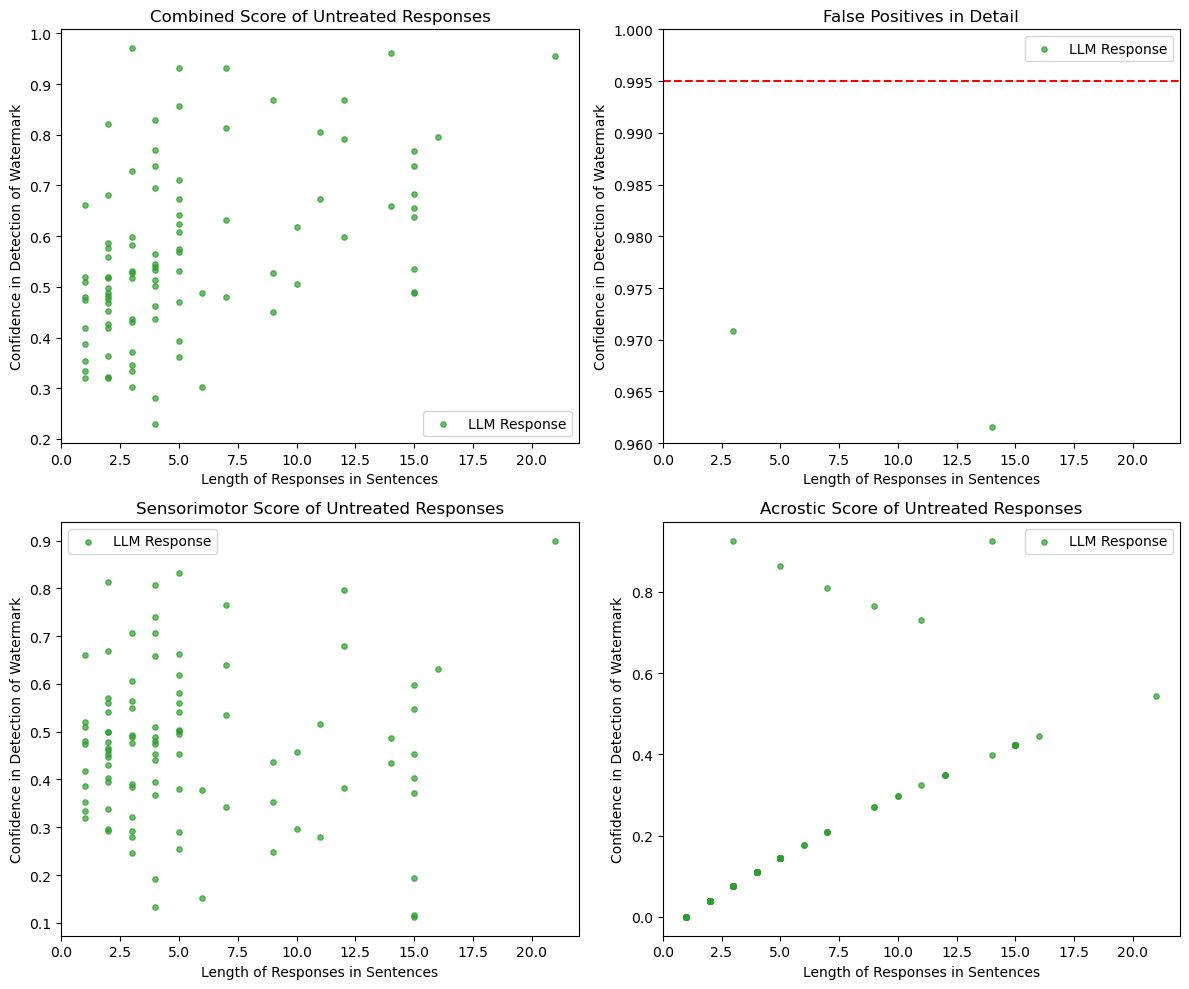

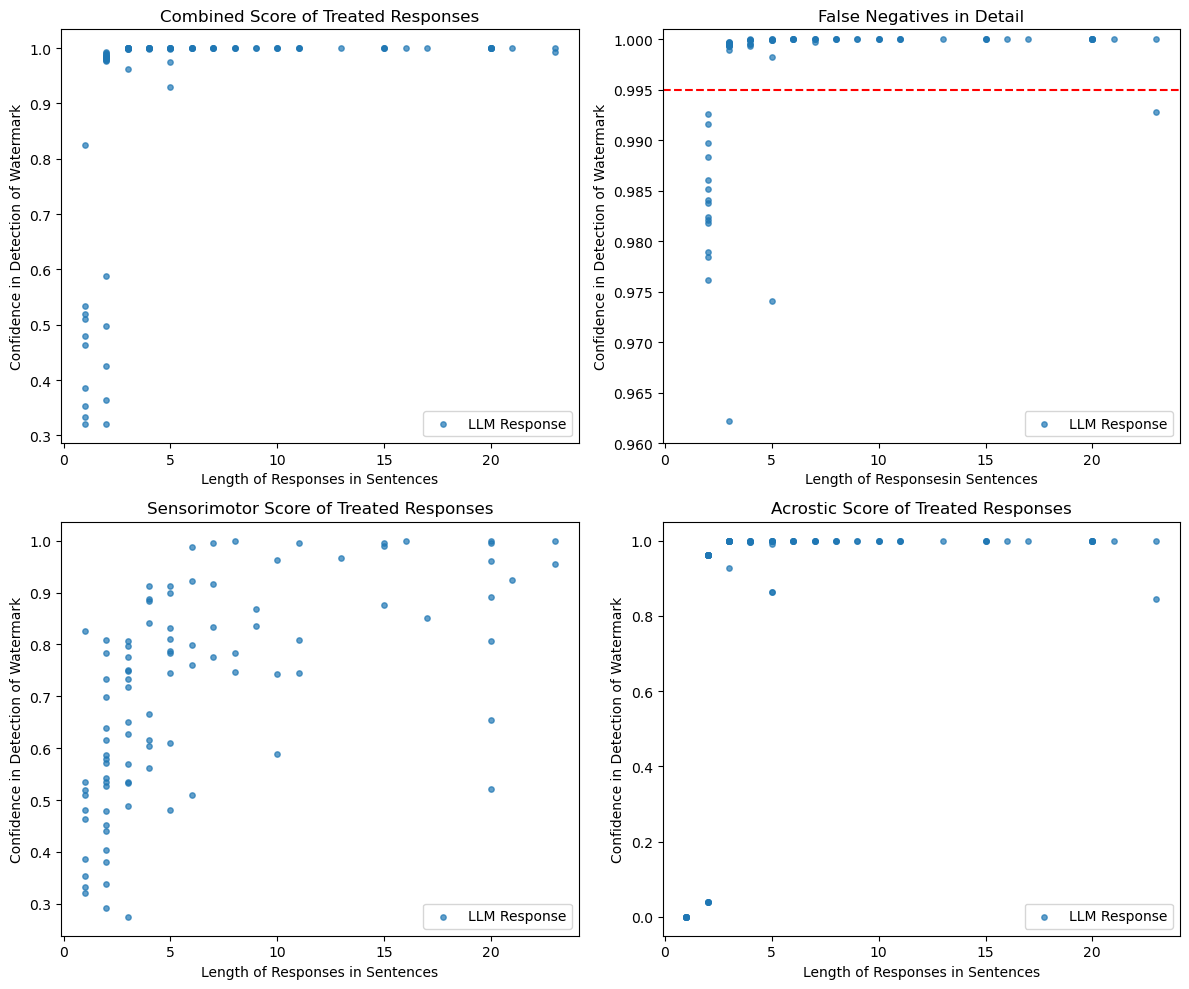

In [6]:
import csv
import ast
import matplotlib.pyplot as plt

# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_score5.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
print(scores)



# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
y_values1 = [1-item[0][0] for item in scores]
x_values1 = [item[0][3] for item in scores]
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('Combined Score of Untreated Responses')
axs[0, 0].legend()

# Subplot 2
y_values2 = [1-item[0][0] for item in scores]
x_values2 = [item[0][3] for item in scores]
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responses in Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('False Positives in Detail')
axs[0, 1].legend()
axs[0, 1].set_ylim(0.96, 1)  # Set the y-axis limit for the lower part
axs[0, 1].axhline(y=0.995, color='red', linestyle='--', label='Red Line')

# Subplot 3
y_values3 = [1-item[0][1] for item in scores]
x_values3 = [item[0][3] for item in scores]
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('Sensorimotor Score of Untreated Responses')
axs[1, 0].legend()

# Subplot 4
y_values4 = [1-item[0][2] for item in scores]
x_values4 = [item[0][3] for item in scores]
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('Acrostic Score of Untreated Responses')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()




# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
y_values1 = [1-item[1][0] for item in scores]
x_values1 = [item[1][3] for item in scores]
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('Combined Score of Treated Responses')
axs[0, 0].legend()

# Subplot 2
y_values2 = [1-item[1][0] for item in scores]
x_values2 = [item[1][3] for item in scores]
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responsesin Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('False Negatives in Detail')
axs[0, 1].legend()
axs[0, 1].set_ylim(0.96, 1.001)  # Set the y-axis limit for the lower part
axs[0, 1].axhline(y=0.995, color='red', linestyle='--', label='Red Line')

# Subplot 3
y_values3 = [1-item[1][1] for item in scores]
x_values3 = [item[1][3] for item in scores]
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('Sensorimotor Score of Treated Responses')
axs[1, 0].legend()

# Subplot 4
y_values4 = [1-item[1][2] for item in scores]
x_values4 = [item[1][3] for item in scores]
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('Acrostic Score of Treated Responses')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()

b_both_TN 75
b_both_FP 3
w_both_TP 83
w_both_FN 3


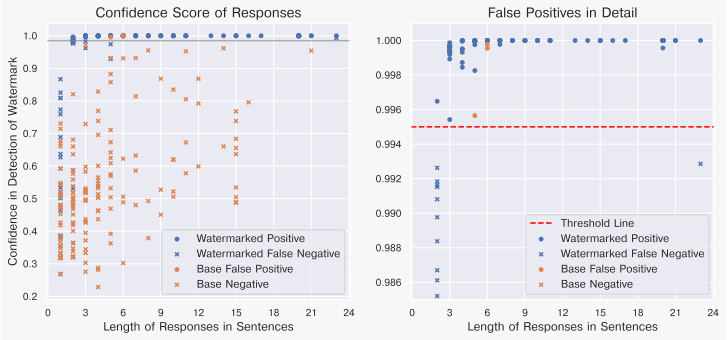

In [3]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_score6.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
#print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1.0-item[1][0] for item in scores]
x_values1 = [item[1][3] for item in scores]

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_both_TP = 0
w_both_FN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_both_TP += 1
    else:
        if x_values[i] > 3:
            w_both_FN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='Watermarked Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='Watermarked False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1.0-item[0][0] for item in scores]
x_values2 = [item[0][3] for item in scores]

#######################################uncomment to print values
#for i in range (0,60):
    #print(f'''&{y_values2[i]} & {y_values1[i]}''')


x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_both_FP = 0
b_both_TN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_both_FP += 1
    else:
        if x_values[i] > 3:
            b_both_TN += 1
# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='Base False Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='Base Negative')


axs[0].set_title('Confidence Score of Responses', fontsize=14)
axs[0].legend()
axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995


# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='Watermarked Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='Watermarked False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('False Positives in Detail', fontsize=14)
axs[1].legend()
axs[1].set_ylim(0.985, 1.001)

x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='Base False Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='Base Negative')
axs[1].legend()

print(f'''b_both_TN {b_both_TN}''')
print(f'''b_both_FP {b_both_FP}''')
print(f'''w_both_TP {w_both_TP}''')
print(f'''w_both_FN {w_both_FN}''')

plt.savefig('paper_plot.png', dpi=300, bbox_inches='tight')

[([0.5297548768676754, 0.5297548768676754, 1.0, 1, 0], [0.19113064636803867, 0.19113064636803867, 1.0, 1, 0]), ([0.6050049348103864, 0.654373337490914, 0.9245562130177515, 3, 0], [3.179014954501153e-23, 0.03556596960190672, 8.938361557646732e-22, 21, 17]), ([0.5362103031281812, 0.6031636664179785, 0.8889963586709148, 4, 0], [1.1405077956561046e-07, 0.23488056715276995, 4.855692446086017e-07, 7, 5]), ([0.49501194173685586, 0.5148124194063302, 0.9615384615384615, 2, 0], [4.564181111474285e-30, 0.0034982954143908396, 1.3046871606951035e-27, 20, 19]), ([0.47958544602195813, 0.5187196184173499, 0.9245562130177515, 3, 0], [0.22653737190337375, 0.22653737190337375, 1.0, 1, 0]), ([0.6519375730788235, 0.6519375730788235, 1.0, 1, 0], [1.183606305405905e-07, 0.24375644020863874, 4.855692446086017e-07, 7, 5]), ([0.4450055943886417, 0.5005707729263851, 0.8889963586709148, 4, 0], [2.0606407554447165e-09, 0.09457528793520686, 2.178836354012956e-08, 8, 6]), ([0.6827634596140901, 0.6827634596140901, 1.

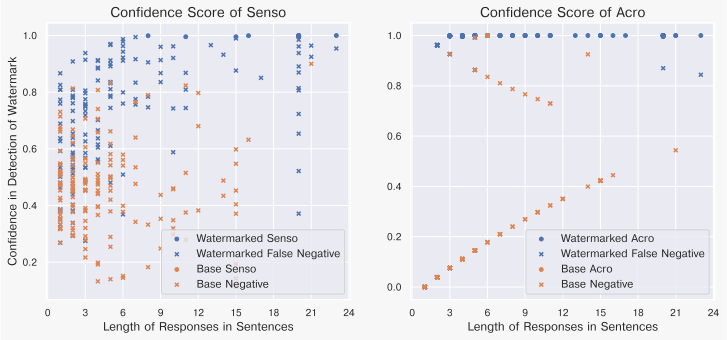

In [4]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_score6.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1-item[1][1] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_senso_TP = 0
w_senso_FN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_senso_TP += 1
    else:
        if x_values[i] > 3:
            w_senso_FN += 1
       

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='Watermarked Senso')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='Watermarked False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1-item[0][1] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_senso_FP = 0
b_senso_TN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_senso_FP += 1
    else:
        if x_values[i] > 3:
            b_senso_TN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='Base Senso')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='Base Negative')





axs[0].set_title('Confidence Score of Senso', fontsize=14)
axs[0].legend()
#axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
#axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

y_values1 = [1-item[1][2] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_acro_TP = 0
w_acro_FN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_acro_TP += 1
    else:
        if x_values[i] > 3:
            w_acro_FN += 1

# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='Watermarked Acro')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='Watermarked False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('Confidence Score of Acro', fontsize=14)
axs[1].legend()
#axs[1].set_ylim(0.985, 1.001)

y_values2 = [1-item[0][2] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_acro_FP = 0
b_acro_TN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_acro_FP += 1
    else:
        if x_values[i] > 3:
            b_acro_TN += 1
            
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='Base Acro')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='Base Negative')
axs[1].legend()


print(f'''b_senso_TN {b_senso_TN}''')
print(f'''b_senso_FP {b_senso_FP}''')
print(f'''w_senso_TP {w_senso_TP}''')
print(f'''w_senso_FN {w_senso_FN}''')
print(f'''b_acro_TN {b_acro_TN}''')
print(f'''b_acro_FP {b_acro_FP}''')
print(f'''w_acro_TP {w_acro_TP}''')
print(f'''w_acro_FN {w_acro_FN}''')

plt.savefig('ablation.png', dpi=300, bbox_inches='tight')

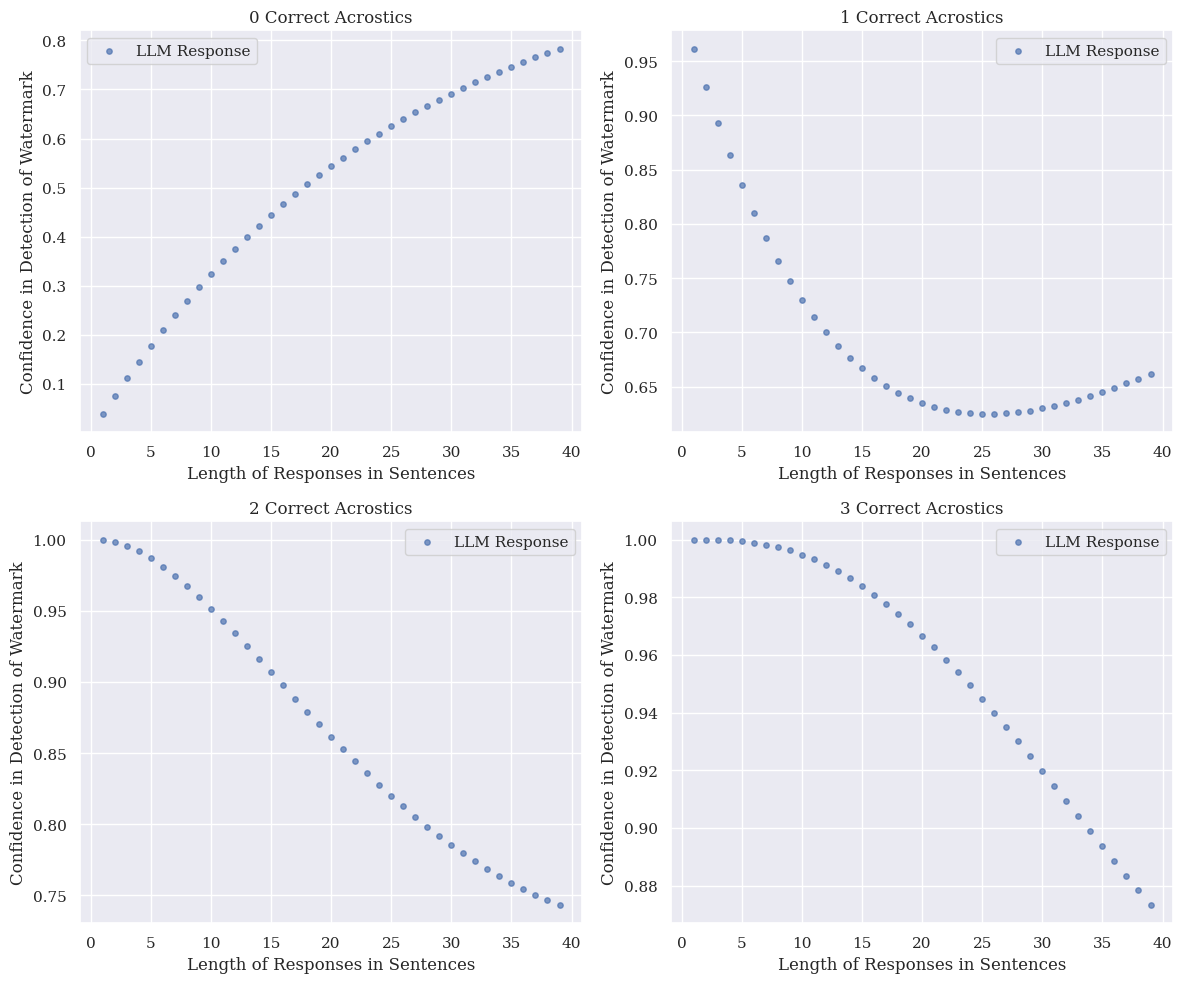

In [81]:
def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
x_values1 = range(1,40)
y_values1 = []
for x in x_values1:
        y_values1.append(1-probability_of_acrosticon(0,x))
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('0 Correct Acrostics')
axs[0, 0].legend()

# Subplot 2
x_values2 = range(1,40)
y_values2 = []
for x in x_values2:
        y_values2.append(1-probability_of_acrosticon(1,x))
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responses in Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('1 Correct Acrostics')
axs[0, 1].legend()

# Subplot 3
x_values3 = range(1,40)
y_values3 = []
for x in x_values3:
        y_values3.append(1-probability_of_acrosticon(2,x))
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('2 Correct Acrostics')
axs[1, 0].legend()

# Subplot 4
x_values4 = range(1,40)
y_values4 = []
for x in x_values4:
        y_values4.append(1-probability_of_acrosticon(3,x))
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('3 Correct Acrostics')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()


In [19]:
import csv
from googletrans import Translator

# Function to translate text
def translate_text(text, target_language='en'):
    if not text:
        return ""  # Return empty string if text is None or empty
    try:
        translator = Translator()
        translation = translator.translate(text, dest=target_language)
        return translation.text
    except Exception as e:
        print(f"Error during translation: {e}")
        return text  # Return the original text if translation fails

# Specify the file name
file_name = "output_gen6.csv"

# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object and convert it to a list
    output_gen = list(csv.reader(csv_file))

# Example usage
translations = []
for text in output_gen:
    # Assuming text[2] is the column with the text to be translated
    # Check if text[2] exists and is not empty
    if len(text) > 2 and text[2]:
        translated_text_watermark = translate_text(text[2], 'es')  # Translate to Spanish
        translated_text_watermark = translate_text(translated_text_watermark, 'en')  # Translate back to English

    else:
        translated_text_watermark = ""

    if len(text) > 2 and text[1]:
        translated_text_base = translate_text(text[1], 'es')  # Translate to Spanish
        translated_text_base = translate_text(translated_text_base, 'en')  # Translate back to English
    else:
        translated_text_base = ""

    if len(text) > 2 and text[0]:
        prompt = text[0]
    else:
        prompt = ""

    
    translations.append([prompt,translated_text_base,translated_text_watermark])

Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JS

In [21]:
import csv

# Specify the file name
file_name = "output_translation_gen6.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(translations)

In [22]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math
import modules.shared as shared

from scipy.stats import binom

def split_into_sentences(text):
    doc = nlp(text)
    sentences = []
    current_sentence = []

    for token in doc:
        current_sentence.append(token.text)
        if token.text in (".", "?", "!"):
            sentences.append(" ".join(current_sentence))
            current_sentence = []

    # Add the last sentence if not followed by a punctuation mark
    if current_sentence:
        sentences.append(" ".join(current_sentence))

    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]


def calculate_probs(reply):
    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    old_class = 0

    sentences = split_into_sentences(reply)
    for idx, sentence in enumerate(sentences, start=1):

        if idx > 1:
            if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
                correct_acrosticons += 1

        range_list = [(0, 10), (0, 25)] 
        generated_numbers = secure_hash_to_numbers(sentence, range_list)


        sum_of_word_mean = 0
        valid_words = 0
        words = get_words_in_sentence(sentence)
        for word in words:
            if word.upper() in shared.sensorimotor:
                valid_words += 1
                sum_of_word_mean += shared.sensorimotor[word.upper()][shared.classes[old_class]]

        if(valid_words > 0):
            sentence_value = sum_of_word_mean/valid_words

            # Calculate Z-score for the new data point
            z_score = (sentence_value - mean_value[old_class]) / std_deviation[old_class]
        else:
            z_score = 0

        # Calculate the probability using the cumulative distribution function (CDF)
        probabilities.append(1-norm.cdf(z_score))
        z_scores.append(z_score)

        old_class = generated_numbers[0]



    def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


    acrosticon_restult = probability_of_acrosticon(correct_acrosticons, len(sentences)-1)
    #print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

    # Example usage:
    stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
    #print(probabilities)
    #print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
    #print(f"The total probability is: {stouffer_result*acrosticon_restult}")

    #return stouffer_result*acrosticon_restult, len(sentences), correct_acrosticons
    return stouffer_result*acrosticon_restult, stouffer_result, acrosticon_restult, len(sentences), correct_acrosticons

scores_translation = []


for tuple in translations:
    score_base, stouffer_result_base, acrosticon_restult_base, len_base, acros_base = calculate_probs(tuple[1])
    score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark = calculate_probs(tuple[2])

    scores_translation.append([[score_base,stouffer_result_base, acrosticon_restult_base,len_base,acros_base],[score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark]])




    

In [23]:
# Specify the file name
file_name = "output_translation_score6.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(scores_translation)

tw_both_TP 20
tw_both_FN 9
tw_senso_FN 25
tw_both_FN 9
tw_acro_TP 15
tw_acro_FN 14


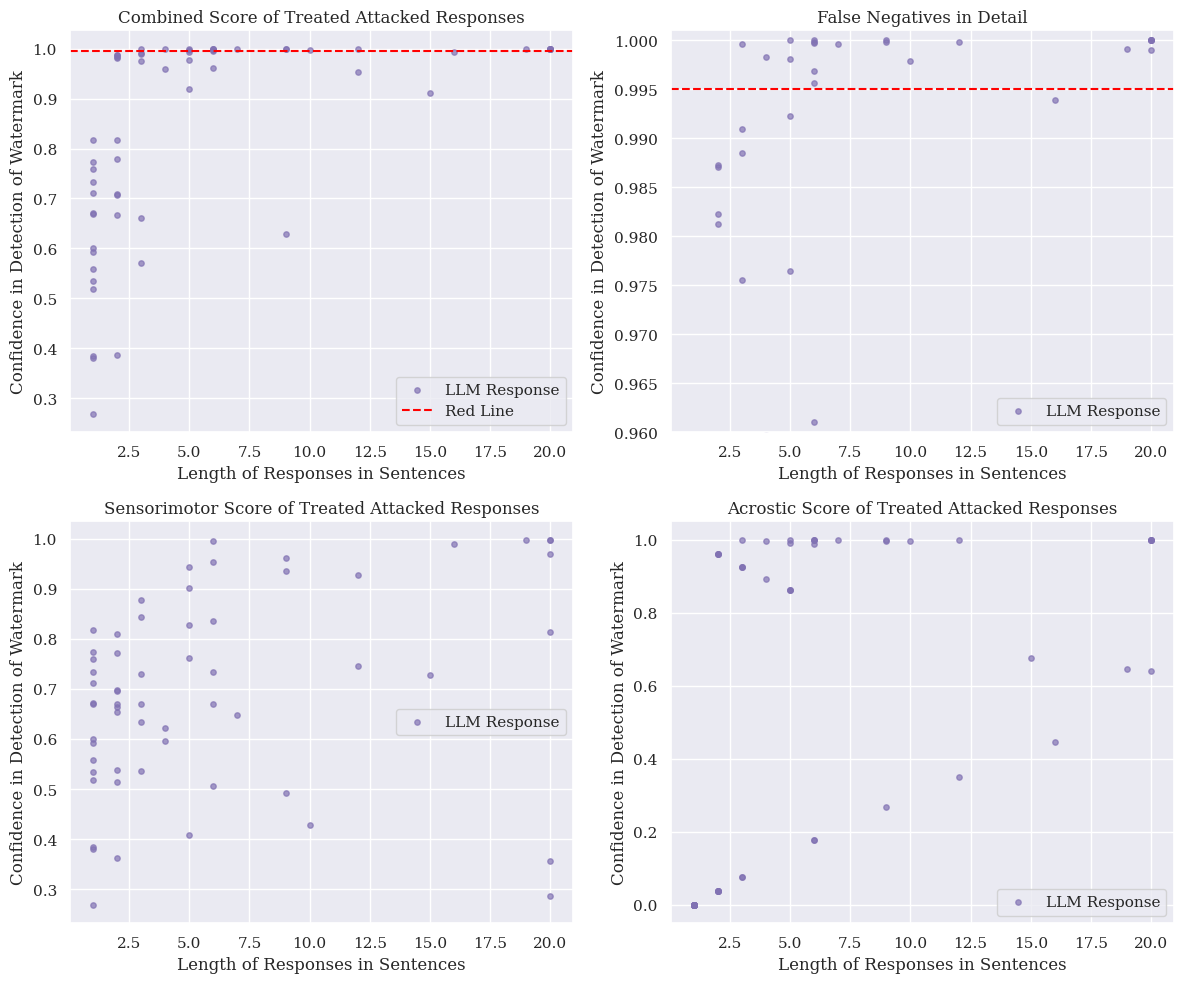

In [41]:
import matplotlib.pyplot as plt

# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_translation5.csv"
file_name = "output_translation5.csv"  # replace with your file name
scores_translation = []

# Open the file and read the contents
with open(file_name, 'r') as file:
    csv_reader = csv.reader(file)
    
    for row in csv_reader:
        # Convert each element in the row to float or int as appropriate
        data_row = [float(item) if '.' in item else int(item) for item in row]
        scores_translation.append(data_row)

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
y_values1 = [1-item[0] for item in scores_translation]
x_values1 = [item[3] for item in scores_translation]
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('Combined Score of Treated Attacked Responses')
axs[0, 0].axhline(y=0.995, color='red', linestyle='--', label='Red Line')
axs[0, 0].legend()

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
tw_both_TP = 0
tw_both_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            tw_both_TP += 1
    else:
        if x_values[i] > 3:
            tw_both_FN += 1



# Subplot 2
y_values2 = [1-item[0] for item in scores_translation]
x_values2 = [item[3] for item in scores_translation]
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responses in Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('False Negatives in Detail')
axs[0, 1].legend()
axs[0, 1].set_ylim(0.96, 1.001)  # Set the y-axis limit for the lower part
axs[0, 1].axhline(y=0.995, color='red', linestyle='--', label='Red Line')




# Subplot 3
y_values3 = [1-item[1] for item in scores_translation]
x_values3 = [item[3] for item in scores_translation]
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('Sensorimotor Score of Treated Attacked Responses')
axs[1, 0].legend()

x_values = np.array(x_values3)
y_values = np.array(y_values3)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
tw_senso_TP = 0
tw_senso_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            tw_senso_TP += 1
    else:
        if x_values[i] > 3:
            tw_senso_FN += 1

# Subplot 4
y_values4 = [1-item[2] for item in scores_translation]
x_values4 = [item[3] for item in scores_translation]
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('Acrostic Score of Treated Attacked Responses')
axs[1, 1].legend()


x_values = np.array(x_values4)
y_values = np.array(y_values4)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
tw_acro_TP = 0
tw_acro_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            tw_acro_TP += 1
    else:
        if x_values[i] > 3:
            tw_acro_FN += 1

print(f'''tw_both_TP {tw_both_TP}''')
print(f'''tw_both_FN {tw_both_FN}''')
print(f'''tw_senso_TP {tw_senso_TP}''')
print(f'''tw_senso_FN {tw_senso_FN}''')
print(f'''tw_acro_TP {tw_acro_TP}''')
print(f'''tw_acro_FN {tw_acro_FN}''')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()



In [24]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_translation5.csv"
file_name = "output_translation5.csv"  # replace with your file name
scores = []

# Open the file and read the contents
with open(file_name, 'r') as file:
    csv_reader = csv.reader(file)
    
    for row in csv_reader:
        # Convert each element in the row to float or int as appropriate
        data_row = [float(item) if '.' in item else int(item) for item in row]
        scores.append(data_row)

print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1-item[:][0] for item in scores]
x_values1 = [item[:][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C4', marker='o', label='Watermarked Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C5', marker='x', label='Watermarked False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



axs[0].set_title('Confidence Score of Translation Attacked Responses', fontsize=14)
axs[0].legend()
axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C4', marker='o', label='Watermarked Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C5', marker='x', label='Watermarked False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('False Positives in Detail', fontsize=14)
axs[1].legend()
axs[1].set_ylim(0.985, 1.001)


axs[1].legend()

plt.savefig('paper_plot_attack.png', dpi=300, bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: 'output_translation5.csv'

b_both_TN 70
b_both_FP 3
w_both_TP 42
w_both_FN 36


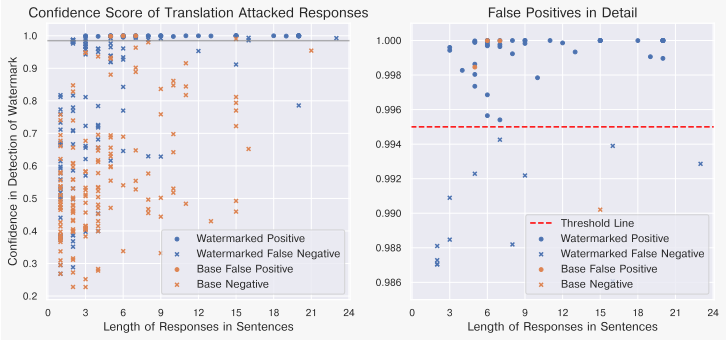

In [2]:
import csv
import ast
#%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_translation_score6.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
#print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1.0-item[1][0] for item in scores]
x_values1 = [item[1][3] for item in scores]

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_both_TP = 0
w_both_FN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_both_TP += 1
    else:
        if x_values[i] > 3:
            w_both_FN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='Watermarked Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='Watermarked False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1.0-item[0][0] for item in scores]
x_values2 = [item[0][3] for item in scores]

#######################################uncomment to print values
#for i in range (0,60):
    #print(f'''&{y_values2[i]} & {y_values1[i]}''')


x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_both_FP = 0
b_both_TN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_both_FP += 1
    else:
        if x_values[i] > 3:
            b_both_TN += 1
# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='Base False Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='Base Negative')


axs[0].set_title('Confidence Score of Translation Attacked Responses', fontsize=14)
axs[0].legend()
axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995


# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='Watermarked Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='Watermarked False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('False Positives in Detail', fontsize=14)
axs[1].legend()
axs[1].set_ylim(0.985, 1.001)

x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='Base False Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='Base Negative')
axs[1].legend()

print(f'''b_both_TN {b_both_TN}''')
print(f'''b_both_FP {b_both_FP}''')
print(f'''w_both_TP {w_both_TP}''')
print(f'''w_both_FN {w_both_FN}''')

plt.savefig('paper_plot_translation.png', dpi=300, bbox_inches='tight')

[([0.5297548768676754, 0.5297548768676754, 1.0, 1, 0], [0.3281204982094562, 0.3281204982094562, 1.0, 1, 0]), ([0.6166518151174941, 0.6669706032310816, 0.9245562130177515, 3, 0], [8.553158817654539e-11, 0.18603365304089636, 4.5976406299855176e-10, 20, 10]), ([0.519091104498668, 0.5839068961707898, 0.8889963586709148, 4, 0], [0.2906362734298562, 0.30226172436705045, 0.9615384615384615, 2, 0]), ([0.594967782715279, 0.6187664940238902, 0.9615384615384615, 2, 0], [4.595478481516161e-13, 0.03054118608804135, 1.504682387995258e-11, 20, 11]), ([0.4929113609549464, 0.53313292800887, 0.9245562130177515, 3, 0], [0.22653737190337375, 0.22653737190337375, 1.0, 1, 0]), ([0.6216508991115235, 0.6216508991115235, 1.0, 1, 0], [0.0003560309241830312, 0.35194742151679437, 0.0010116025929345867, 7, 3]), ([0.5350870127442552, 0.5350870127442552, 1.0, 1, 0], [0.0043513289140891835, 0.3308785595389778, 0.013150833708149628, 6, 2]), ([0.6626609602814836, 0.6626609602814836, 1.0, 1, 0], [0.6191067768285119, 0.6

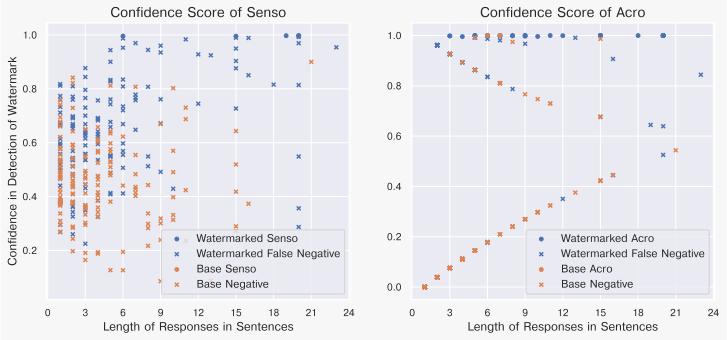

In [5]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_translation_score6.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1-item[1][1] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_senso_TP = 0
w_senso_FN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_senso_TP += 1
    else:
        if x_values[i] > 3:
            w_senso_FN += 1
       

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='Watermarked Senso')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='Watermarked False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1-item[0][1] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_senso_FP = 0
b_senso_TN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_senso_FP += 1
    else:
        if x_values[i] > 3:
            b_senso_TN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='Base Senso')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='Base Negative')





axs[0].set_title('Confidence Score of Senso', fontsize=14)
axs[0].legend()
#axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
#axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

y_values1 = [1-item[1][2] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_acro_TP = 0
w_acro_FN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_acro_TP += 1
    else:
        if x_values[i] > 3:
            w_acro_FN += 1

# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='Watermarked Acro')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='Watermarked False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('Confidence Score of Acro', fontsize=14)
axs[1].legend()
#axs[1].set_ylim(0.985, 1.001)

y_values2 = [1-item[0][2] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_acro_FP = 0
b_acro_TN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_acro_FP += 1
    else:
        if x_values[i] > 3:
            b_acro_TN += 1
            
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='Base Acro')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='Base Negative')
axs[1].legend()


print(f'''b_senso_TN {b_senso_TN}''')
print(f'''b_senso_FP {b_senso_FP}''')
print(f'''w_senso_TP {w_senso_TP}''')
print(f'''w_senso_FN {w_senso_FN}''')
print(f'''b_acro_TN {b_acro_TN}''')
print(f'''b_acro_FP {b_acro_FP}''')
print(f'''w_acro_TP {w_acro_TP}''')
print(f'''w_acro_FN {w_acro_FN}''')

#plt.savefig('ablation.png', dpi=300, bbox_inches='tight')

In [8]:

prompts = [\
    "How do I write a good paper?"
    #"What is a watermark?"
    #"What is motorsports, is it a real sport?",
]



results = []


for prompt in prompts:
#prompt = "What is the capital of France?"
    question = f'''<|im_start|>system
You are a helpful assistant, who always provide explanation. Don't enumerate anwsers, talk for the user, write links or urls or use numbers.<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start>assistant
'''

    generate_params = {
        'max_new_tokens' : 200,
        'add_bos_token' : False,
        'truncation_length' : 4096,
        'custom_stopping_strings' : ["### Human:", "Human:", "user:", "Q:","<|im_end|>","<|im_start|>system"],
        'ban_eos_token' : False,
        'skip_special_tokens' : False,
        'do_sample': True,
        'temperature': 0.7,
        'top_p': 0.95,
        'typical_p': 1,
        'repetition_penalty': 1.10,
        'encoder_repetition_penalty': 1,
        'top_k': 40,
        'num_beams': 1,
        'penalty_alpha': 0,
        'min_length': 0,
        'length_penalty': 1,
        'no_repeat_ngram_size': 0,
        'early_stopping': False,
        'seed' : 0,
    }

    #no watermark
    shared.delta_char = 0.0
    shared.delta_first = 0.0
    shared.secret_key = [0,0]
    done = False
    reply_base = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    i = 0
    while (done is not True and i < 4):
        reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

        last_sentence = get_last_sentence(reply_current)
        #print("------------------found end of sentence, last sentence is:")
        #print(f'''[{reply_current}]''')
        shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
        shared.new_sentence = True
        shared.start = 0
        reply_base += reply_current
        current_question = f'''{current_question}{reply_current}'''
        i+=1

    #only senso
    shared.delta_char = 2.5#2.5
    shared.delta_first = 0.0#50
    shared.secret_key = [0,0]
    done = False
    reply_senso = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    i = 0
    while (done is not True and i < 4):
        reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

        last_sentence = get_last_sentence(reply_current)
        #print("------------------found end of sentence, last sentence is:")
        #print(f'''[{reply_current}]''')
        shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
        shared.new_sentence = True
        shared.start = 0
        reply_senso += reply_current
        current_question = f'''{current_question}{reply_current}'''
        i+=1

    #only acro
    shared.delta_char = 0.0#2.5
    shared.delta_first = 20.0#50
    shared.secret_key = [0,0]
    done = False
    reply_acro = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    i = 0
    while (done is not True and i < 4):
        reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

        last_sentence = get_last_sentence(reply_current)
        #print("------------------found end of sentence, last sentence is:")
        #print(f'''[{reply_current}]''')
        shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
        shared.new_sentence = True
        shared.start = 0
        reply_acro += reply_current
        current_question = f'''{current_question}{reply_current}'''
        i+=1

    #both
    shared.delta_char = 2.5#2.5
    shared.delta_first = 20.0#50
    shared.secret_key = [0,0]
    done = False
    reply_watermark = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    i = 0
    while (done is not True and i < 4):
        reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

        last_sentence = get_last_sentence(reply_current)
        #print("------------------found end of sentence, last sentence is:")
        #print(f'''[{reply_current}]''')
        shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
        shared.new_sentence = True
        shared.start = 0
        reply_watermark += reply_current
        current_question = f'''{current_question}{reply_current}'''
        i+=1



    #results.append([prompt,reply_base,reply_watermark])
    results.append([prompt,reply_base,reply_senso,reply_acro,reply_watermark])


    #reply_watermark = generate_reply(question+reply_watermark, generate_params, eos_token='<|im_end|>')
    print(prompt)
    print(f'''[{reply_base}]''')
    print(f'''[{reply_senso}]''')
    print(f'''[{reply_acro}]''')
    print(f'''[{reply_watermark}]''')

Output generated in 1.04 seconds (11.58 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.40 seconds (13.56 tokens/s, 19 tokens, context 96, seed 0)
Output generated in 1.45 seconds (14.52 tokens/s, 21 tokens, context 115, seed 0)
Output generated in 1.46 seconds (13.70 tokens/s, 20 tokens, context 135, seed 0)
Output generated in 0.99 seconds (12.15 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.81 seconds (14.91 tokens/s, 27 tokens, context 96, seed 0)
Output generated in 1.69 seconds (14.81 tokens/s, 25 tokens, context 123, seed 0)
Output generated in 1.20 seconds (11.64 tokens/s, 14 tokens, context 147, seed 0)
Output generated in 1.00 seconds (11.98 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.83 seconds (16.40 tokens/s, 30 tokens, context 96, seed 0)
Output generated in 1.65 seconds (13.98 tokens/s, 23 tokens, context 126, seed 0)
Output generated in 1.06 seconds (11.35 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.8

In [20]:
results2 = [["What is motorsports, is it a real sport?",
             "Motorsports is a sport that uses vehicles for competition. Many people consider motorsports to be a form of racing, but they can also be classified as an extreme sport due to the level of danger and physical exertion involved.The term motorsport is used to refer to many different types of competitions involving motorized vehicles.The most common type of motorsport is car racing, which includes events such as Formula One, NASCAR, and rallying.",
            "Motorsports is a sport that uses vehicles for competition. Many people disagree because they say that it is dangerous and cruel to animals, but what do you think? You can share your opinion on social network like facebook or you can comment this forum.",
            " Motorsports is a sport that uses vehicles for competition. Races can be held on land, water, ice, or snow, and may be based on speed, distance, or performance criteria such as endurance or durability. Races may also involve other forms of human-propelled vehicle or animal. Racers usually compete against each other, but races may also be against time.",
            " Motorsports is a sport that uses vehicles for competition. Rallying and rallycross are popular forms of motorsport. Car racing can take many different forms, such as drag racing, dirt track racing, rally racing, stock car racing, touring car racing, sports car racing, open wheel racing and kart racing. Understanding the differences between these forms of racing, as well as the racing world in general, is difficult if you do not follow racing closely"]]

In [28]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math
import modules.shared as shared

from scipy.stats import binom

def split_into_sentences(text):
    doc = nlp(text)
    sentences = []
    current_sentence = []

    for token in doc:
        current_sentence.append(token.text)
        if token.text in (".", "?", "!"):
            sentences.append(" ".join(current_sentence))
            current_sentence = []

    # Add the last sentence if not followed by a punctuation mark
    if current_sentence:
        sentences.append(" ".join(current_sentence))

    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]


def calculate_probs(reply):
    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    old_class = 0

    sentences = split_into_sentences(reply)
    for idx, sentence in enumerate(sentences, start=1):
        print(sentence)
        if idx > 1:
            if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
                
                correct_acrosticons += 1

        range_list = [(0, 10), (0, 25)] 
        generated_numbers = secure_hash_to_numbers(sentence, range_list)


        sum_of_word_mean = 0
        valid_words = 0

        color_text = ""

        words = get_words_in_sentence(sentence)
        for word in words:
            if word.upper() in shared.sensorimotor:
                valid_words += 1
                sum_of_word_mean += shared.sensorimotor[word.upper()][shared.classes[old_class]]
                #print(f'''{word} : P={shared.sensorimotor[word.upper()][shared.classes[old_class]]}''')
                
                #color_text += f'''\colorword{{{val}}}{{{word}}} '''
                if shared.sensorimotor[word.upper()][shared.classes[old_class]] > mean_value[old_class]:
                    val = (shared.sensorimotor[word.upper()][shared.classes[old_class]]/5)*100
                    color_text += f'''\colorhighlight{{red}}{{{val}}}{{{word}}}'''
                else:
                    val = (shared.sensorimotor[word.upper()][shared.classes[old_class]]/5)*100
                    color_text += f'''\colorhighlight{{red}}{{{0}}}{{{word}}}'''
            else:
                color_text += f'''\colorhighlight{{red}}{{{0}}}{{{word}}}'''

        #print(color_text)
        
        if(valid_words > 0):
            sentence_value = sum_of_word_mean/valid_words
            print(f'''valid words {valid_words}, word mean {sum_of_word_mean}, sentence_value {sentence_value}''')

            
            # Calculate Z-score for the new data point
            z_score = (sentence_value - mean_value[old_class]) / std_deviation[old_class]
        else:
            z_score = 0

        # Calculate the probability using the cumulative distribution function (CDF)
        probabilities.append(1-norm.cdf(z_score))
        z_scores.append(z_score)

        old_class = generated_numbers[0]



    def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


    acrosticon_restult = probability_of_acrosticon(correct_acrosticons, len(sentences)-1)
    #print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

    # Example usage:
    stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
    #print(probabilities)
    #print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
    #print(f"The total probability is: {stouffer_result*acrosticon_restult}")

    #return stouffer_result*acrosticon_restult, len(sentences), correct_acrosticons
    return stouffer_result*acrosticon_restult, stouffer_result, acrosticon_restult, len(sentences), correct_acrosticons

scores = []
for tuple in results2:
    score_base, stouffer_result_base, acrosticon_restult_base, len_base, acros_base = calculate_probs(tuple[1])

    score_senso, stouffer_result_senso, acrosticon_restult_senso, len_senso, acros_senso = calculate_probs(tuple[2])
    score_acro, stouffer_result_acro, acrosticon_restult_acro, len_acro, acros_acro = calculate_probs(tuple[3])

    score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark = calculate_probs(tuple[4])

    scores.append([[score_base,stouffer_result_base, acrosticon_restult_base,len_base,acros_base],[score_senso, stouffer_result_senso, acrosticon_restult_senso, len_senso, acros_senso],[score_acro, stouffer_result_acro, acrosticon_restult_acro, len_acro, acros_acro],[score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark]])

print(scores)

Motorsports is a sport that uses vehicles for competition .
\colorhighlight{red}{0}{Motorsports}\colorhighlight{red}{30.52631578}{is}\colorhighlight{red}{44.28571428}{a}\colorhighlight{red}{80.0}{sport}\colorhighlight{red}{0}{that}\colorhighlight{red}{0}{uses}\colorhighlight{red}{0}{vehicles}\colorhighlight{red}{0}{for}\colorhighlight{red}{50.588235299999994}{competition}
valid words 6, word mean 12.638434320999998, sentence_value 2.1064057201666664
Many people consider motorsports to be a form of racing , but they can also be classified as an extreme sport due to the level of danger and physical exertion involved .
\colorhighlight{red}{0}{Many}\colorhighlight{red}{63.52941176}{people}\colorhighlight{red}{28.181818179999997}{consider}\colorhighlight{red}{0}{motorsports}\colorhighlight{red}{34.7368421}{to}\colorhighlight{red}{29.473684219999996}{be}\colorhighlight{red}{0}{a}\colorhighlight{red}{0}{form}\colorhighlight{red}{0}{of}\colorhighlight{red}{0}{racing}\colorhighlight{red}{0}{but